## Example using constrained GP model
This is the code used to produce the 'corroded pipeline' example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

### Imports

In [1]:
### Basic imports ###
import sys, os

# For plotting
import plotly
import plotly.plotly as pltly
import plotly.graph_objs as go
import plotly.offline as pltlyoff
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE
import pandas as pd

### Custom files ###

# Path to custom plotly module 'GPPlotly' for plotting 
# can be downloaded at https://github.com/cagrell/gp_plotly
dir_GPPlotly = 'C:\\Data\\git repos\\gp_plotly\\'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = 'C:\\Data\\git repos\\gp_constr\\'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig, gp_diagnostics, pred_vs_error_perc
from GPConstr.model import kernel_RBF, GPmodel, Constraint

### Setup notebook ###
pltlyoff.init_notebook_mode(connected=True)
print('Python version', sys.version)

Loading constrained GP module from C:\Data\git repos\gp_constr
Loading R wrapper...
Running R from rpy2: R version 3.4.3 (2017-11-30)


Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]


## 1. Define function for generating synthetic test/training data
Function based on (proportional to) simplified pipe burst capacity in RP-F101

$P_{cap}(\sigma_{u}, D, t, d, l) = \frac{t \sigma_{u}}{D - t} \frac{1 - d/t}{1 - \frac{d/t}{Q}}$, $Q = \sqrt{1 + 0.31\frac{l^{2}}{Dt}}$

We have the following constraints

1.) $0 \leq P_{cap} \leq \frac{t \sigma_{u}}{D - t}$

2.) $\frac{\partial P_{cap}}{\partial \sigma_{u}} > 0$

3.) $\frac{\partial P_{cap}}{\partial D} < 0$

4.) $\frac{\partial P_{cap}}{\partial t} > 0$

5.) $\frac{\partial P_{cap}}{\partial d} < 0$

6.) $\frac{\partial P_{cap}}{\partial l} < 0$

In [21]:
# Function to emulate/estimate
def burst_cap(su, D, t, d, l):
    """ 
    Returns number proportional to burst capacity in RP-F101 
    
    Input:    
    su =  Ultimate tensile strength [-]
    D  =  Pipe diameter             [mm]
    t  =  Pipe wall thickness       [mm]
    d  =  Defect depth              [mm]
    l  =  Defect length             [mm]

    """
    
    p0 = t*su/(D-t)                    # Un-corroded capacity
    Q = np.sqrt(1 + 0.31*(l**2)/(D*t)) # Length factor
    d_t = d/t                          # Relative depth
    R = (1-d_t)/(1 - d_t/Q)             # Capacity reduction factor due to the defect
    
    p_cap = p0*R                       # Capacity of pipe with defect
    
    print('R', R)
    print('Q', Q)
    
    return p_cap
    

def fun(x):
    """ function used to generate data """
    
    su = x[0] # Ultimate tensile strength [-]
    D = x[1]  # Pipe diameter [mm]
    t = x[2]  # Pipe wall thickness [mm]
    d = x[3]  # Defect depth [mm]
    l = x[4]  # Defect length [mm]
    
    p_cap = burst_cap(su, D, t, d, l)
    
    return p_cap

def fun_mult(X):
    """ For multiple x in array X """
    return np.array([fun(X[i,:]) for i in range(X.shape[0])])

In [22]:
burst_cap(su = 1, D = 300, t = 7, d = 0, l = 0)

R 1.0
Q 1.0


0.023890784982935155

In [27]:
burst_cap(su = 1, D = 400, t = 8, d = 1, l = 10)

R 0.9993134946347294
Q 1.0048320755230697


0.02039415295172917

In [31]:
burst_cap(su = 1, D = 200, t = 8, d = 1, l = 10)

R 0.9986377206912833
Q 1.0096410253154335


0.04160990502880347

In [ ]:
x = np.linspace(0, 1, 100)
y = 

## 2. Emulation (no noise) in $\mathbb{R}^{4}$

### 2.1. Generate synthetic training data

In [3]:
# Design data - no noise
n_samples = 40
input_dim = 4

x_design = pyDOE.lhs(input_dim, samples = n_samples, criterion = 'maximin', iterations = 1000)
y_design = fun_mult(x_design)

### 2.2. Define GP model (without constraints)

In [4]:
# Set up model
ker = kernel_RBF(variance = 1, lengthscale = [1]*input_dim)
model = GPmodel(kernel = ker, likelihood = 1E-6, mean = 0) # No Noise

# Training data
model.X_training = x_design
model.Y_training = y_design

In [5]:
# Optimize
model.optimize(include_constraint = False, fix_likelihood = True)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.061 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 4 
   lenghtscale = [0.96645648 1.03179132 0.15947514 0.20560625] 
   variance = 0.3783791463266739 
 constraint: 
   No constraints 
---------------------


#### Test the unconstrained model 

In [6]:
# Helper function - put test data in dataframe
def get_diagnostics_df(x_test, y_test, mean, var):
    df = pd.DataFrame(x_test)
    df.columns = ['x' + str(i+1) for i in range(x_test.shape[1])]
    df['y_true'] = y_test
    df['y_mean'] = mean
    df['y_var'] = var
    
    return df

In [7]:
# Test data
n_test = 100
x_test = np.random.rand(n_test, input_dim) # Uniform samples
y_test = fun_mult(x_test)

# Run unconstrained model
mean_unconstr, var_unconstr = model.calc_posterior_unconstrained(x_test, full_cov = False)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.array(var_unconstr).flatten()

# Collect data in df
df_unconstr = get_diagnostics_df(x_test, y_test, mean_unconstr, var_unconstr)


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.004 seconds


In [8]:
# View first couple of records of dataframe with testing data
df_unconstr.head()

,x1,x2,x3,x4,y_true,y_mean,y_var
0,0.719624,0.802144,0.791913,0.006374,0.426977,0.352979,0.141203
1,0.054141,0.094344,0.973876,0.940919,0.134557,0.492821,0.103740
2,0.098658,0.101431,0.826395,0.295651,0.118600,0.172996,0.015851
3,0.685538,0.530512,0.748988,0.022202,0.066063,0.172388,0.087404
4,0.410754,0.823778,0.708996,0.079066,0.090474,0.267725,0.101815


In [9]:
# Plot diagnostics
figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = True)
for fig in figs:
    pltlyoff.iplot(fig, filename='')

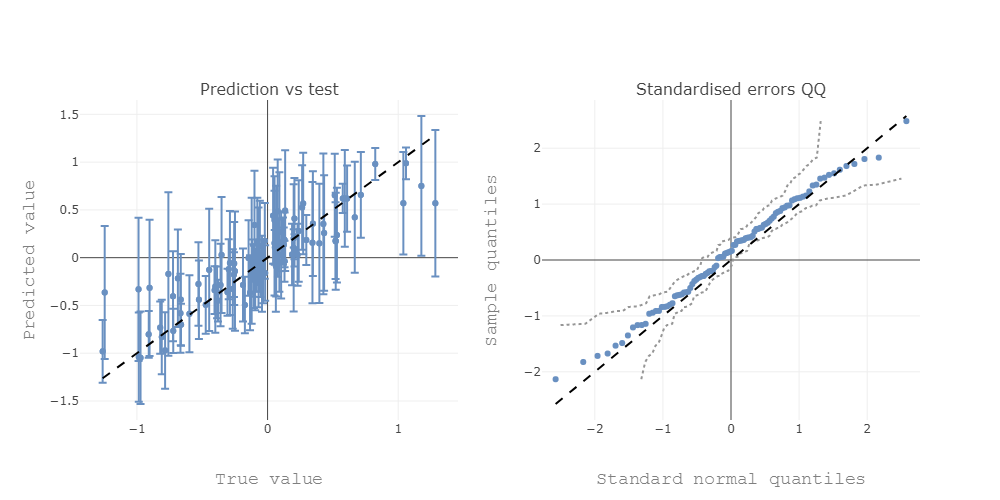

In [10]:
# Show plots as static image
Image(pio.to_image(figs[0], width=1000, height=500, scale=1, format='png'))

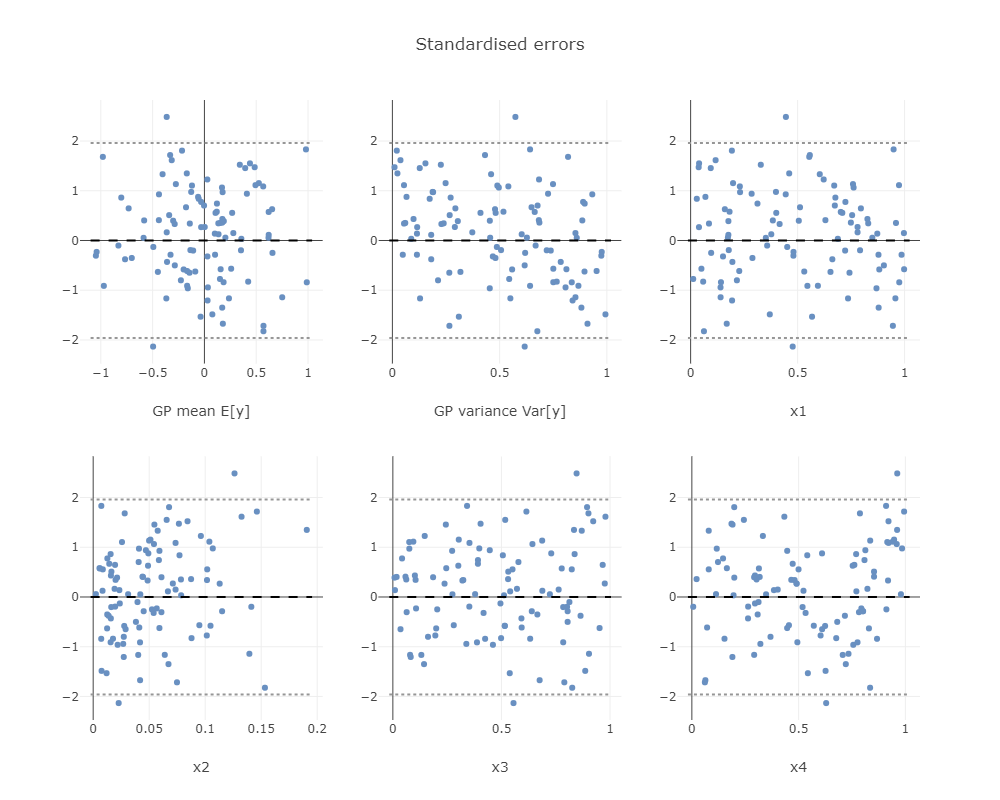

In [11]:
Image(pio.to_image(figs[1], width=1000, height=800, scale=1, format='png'))

#### Plot a 1D slice of the model

In [12]:
plot_x_dim = 1 # Dimension to plot
x_base_val = 0.9 # All other x has this value

# Test input
px_test = np.linspace(0, 1, 100)
px_test_arr = np.ones((len(px_test), input_dim))*x_base_val
px_test_arr[:,plot_x_dim] = px_test

# True function
y_true = fun_mult(px_test_arr)

# From GP
mean_unconstr, cov_unconstr = model.calc_posterior_unconstrained(px_test_arr, full_cov = True)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.diagonal(cov_unconstr)

num_samples = 10
show_samplepaths = True
samplepaths_unconstr = []
if show_samplepaths: samplepaths_unconstr = np.random.multivariate_normal(mean_unconstr, cov_unconstr, num_samples).T

fig_unconstr_slice = PlotGP2d(x_mean = px_test, mean = mean_unconstr, var = var_unconstr,
                        x_true = px_test, y_true = y_true,
                        samplepaths = samplepaths_unconstr,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val), xrange = [0, 1], smoothing = False)

pltlyoff.iplot(fig_unconstr_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.003 seconds


### 2.2.3. Include the constraint that $\text{sgn}(\frac{\partial f}{\partial x_{i}})$ is known for $i = 1, 2$

In [13]:
# Helper functions for constraints

def fun_diff(x, i):
    """ return df/dx_i """
    eps = 0.001
    x2 = x.copy()
    x2[i] = x2[i] + eps
    f2 = fun(x2)
    f1 = fun(x)
    return (f2 - f1)/eps

def fun_diff_mult(X, i):
    """ For multiple x in array X """
    return np.array([fun_diff(X[j,:], i) for j in range(X.shape[0])])

def gen_diff_LB(i):
    def fun(x):
        y = fun_diff_mult(x, i)
        res = np.zeros(x.shape[0])
        res[y <= 0] = float('-inf')
        return res
    return fun

def gen_diff_UB(i):
    def fun(x):
        y = fun_diff_mult(x, i)
        res = np.zeros(x.shape[0])
        res[y >= 0] = float('inf')
        return res
    return fun


In [14]:
# Create derivative constraints
constr_dim = 2
constr_deriv = [Constraint(LB = gen_diff_LB(i), UB = gen_diff_UB(i)) for i in range(constr_dim)]

In [15]:
# Add constraints to model
model.constr_deriv = constr_deriv
model.constr_likelihood = 1E-3

In [16]:
# Define seed-set of virtual observation locations 
# (same set for all constraints in this case)
x_seed = pyDOE.lhs(input_dim, samples = 40, criterion = 'maximin', iterations = 1000)
for constr in model.constr_deriv:
    constr.Xv = x_seed

print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = RBF 
   input dim = 4 
   lenghtscale = [0.96645648 1.03179132 0.15947514 0.20560625] 
   variance = 0.3783791463266739 
 constraint: 
   df/dx_1 [100], df/dx_2 [100] 
   constr_likelihood = 0.001 
---------------------


In [ ]:
# Optimize hyperparameters
model.optimize(include_constraint = True, fix_likelihood = True)
print(model)

In [ ]:
# Find XV 
bounds = [(0.001, 1)]*input_dim
p_target = 0.6

df = model.find_XV_subop(bounds, p_target, min_prob_unconstr_xv = 1E-100, max_iterations = 20)

In [17]:
# Print constraint probability P(C)
model.constrprob_Xv()

1.292875707935022e-20

#### Test the constrained model 

In [18]:
percentiles = [0.025, 0.5, 0.975]
mean, var, perc, mode, samples = model.calc_posterior_constrained(x_test, compute_mode = False, num_samples = 1000, save_samples = 30, algorithm = 'minimax_tilting', resample = False)
mean = np.array(mean).flatten()
lower = perc[0]
upper = perc[2]
var = np.array(var).flatten()

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.002 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.005 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 2 minutes 18.4 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.019 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 2 minutes 18.4 seconds


In [19]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')

In [ ]:
# Show plot as static image
Image(pio.to_image(fig, width=700, height=500, scale=1, format='png'))

#### Plot a 1D slice of the constrained model

In [20]:
# Plot constrained
mean, var, perc, mode, samples = model.calc_posterior_constrained(px_test_arr, compute_mode = False, num_samples = 1000, algorithm = 'minimax_tilting', resample = False)

p_lower = perc[0]
p_upper = perc[2]
p_label = '[p{}, p{}] conf.'.format(10, 90)

samplepaths_Z = []
if show_samplepaths: 
    samplepaths_Z = np.array(samples)

fig_constrained_1 = PlotGP2d(x_mean = px_test, mean = np.array(mean).flatten(),
                        samplepaths =  samplepaths_Z,
                        x_true = px_test, y_true = y_true,
                        p_lower = p_lower, p_upper = p_upper, p_label = p_label,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val))

pltlyoff.iplot(fig_constrained_1, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.000 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.004 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Ychol jitter added.. 4.05006715684593e-09
 DONE - time: 0.022 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 0.066 seconds


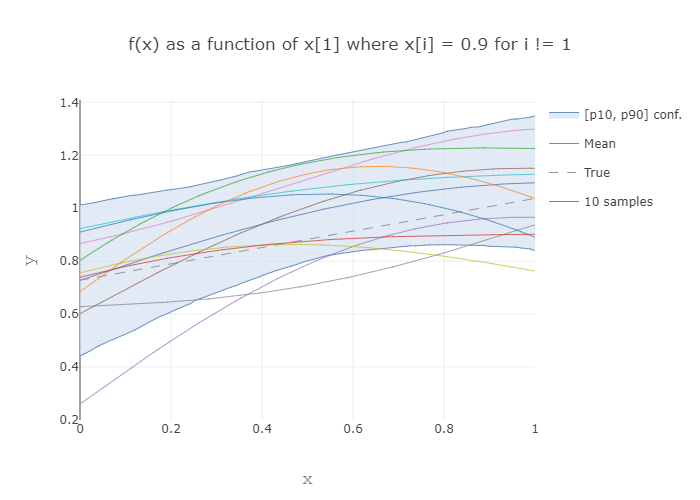

In [21]:
# Show plot as static image
Image(pio.to_image(fig_constrained_1, width=700, height=500, scale=1, format='png'))